In [1]:
# docker run --gpus all -it -v $(realpath ~/):/tf/All -v /home/rob/Data2:/home/rob/Data2 --env HF_DATASETS_CACHE=/home/rob/Data2/huggingface/datasets --env TRANSFORMERS_CACHE=/home/rob/Data2/huggingface/transformers -p 8888:8888 -p 6006:6006 d139afc9cfb2

# 2nd pass ...
# Run Date: Thursday, January 19, 2023
# Run Time: 00:32:25

# First run ...
# Run Date: Thursday, January 19, 2023
# Run Time: 00:30:59

In [2]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

In [3]:
# only target the 2070 Super ...
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Chapter 3: Word2vec - Learning Word Embeddings

** Warning **:This code can consume a significant amount of memory. If you have significantly large RAM memory (>4GB) you do not need to worry. Otherwise please reduce the `batch_size` or `embedding_size` parameter to allow the model to fit in memory.

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/packt_nlp_tensorflow_2/blob/master/Ch03-Word-Vectors/ch3_word2vec.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import zipfile
import re
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from adjustText import adjust_text

2023-01-19 13:27:24.395460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 13:27:24.998778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 13:27:24.998838: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 13:27:24.998846: W tensorfl

## Understanding the data

### Downloading the data

This code downloads a [BBC dataset](hhttp://mlg.ucd.ie/files/datasets/bbc-fulltext.zip) consisting of news articles published by BBC. 

In [5]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')
  
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'bbc')
    if not os.path.exists(extract_path):
        
        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)
  
    else:
        print("bbc-fulltext.zip has already been extracted")
    
download_data(url, 'data')

File already exists
bbc-fulltext.zip has already been extracted


### Read Data without Preprocessing 
Reads data as it is to a string and tokenize it using spaces and returns a list of words

In [6]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []
    
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'README' in f:
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as f:
                
                story = []
                # Read all the lines
                for row in f:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                
        print('', end='\r')
        
    print(f"\nDetected {len(news_stories)} stories")
    return news_stories
                
  
news_stories = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print(f"{sum([len(story.split(' ')) for story in news_stories])} words found in the total news set")
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Build a Tokenizer



In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' '
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


### Exploring the tokenizer

In [8]:
n_vocab = len(tokenizer.word_index.items()) + 1
print(f"Vocabulary size: {n_vocab}")

print("\nWords at the top")
print('\t', dict(list(tokenizer.word_index.items())[:10]))
print("\nWords at the bottom")
print('\t', dict(list(tokenizer.word_index.items())[-10:]))

Vocabulary size: 32360

Words at the top
	 {'the': 1, 'to': 2, 'of': 3, 'and': 4, 'a': 5, 'in': 6, 'for': 7, 'is': 8, 'that': 9, 'on': 10}

Words at the bottom
	 {'bhi': 32350, 'kahey': 32351, 'amitabh': 32352, 'bachchan': 32353, 'aamir': 32354, 'backdrop': 32355, 'toby': 32356, 'eastwards': 32357, 'sweetheart': 32358, 'determines': 32359}


### Build a Tokenizer (Refined)

Here, we will restrict the vocabulary to 15000 and eleminate words except the first most common 15000 words 

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

n_vocab = 15000 + 1
tokenizer = Tokenizer(
    num_words=n_vocab-1,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', oov_token='',    
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


### Checking the results of the tokenizer

In [10]:
print(f"Original: {news_stories[0][:100]}")
print(f"Sequence IDs: {tokenizer.texts_to_sequences([news_stories[0][:100]])[0]}")

Original: Gadgets galore on show at fair  The 2005 Consumer Electronics Show in Las Vegas is a geek's paradise
Sequence IDs: [1143, 1, 11, 151, 21, 1197, 2, 212, 511, 1392, 151, 7, 3130, 3218, 9, 6, 1, 11185]


### Converting all articles to word ID sequences

In [11]:
news_sequences = tokenizer.texts_to_sequences(news_stories)

## Generating skip-grams from the corpus

In TensorFlow you have the convenient `tf.keras.preprocessing.sequence.skipgrams()` function to generate skipgrams. 

In [12]:


sample_word_ids = news_sequences[0][:5]
sample_phrase = ' '.join([tokenizer.index_word[wid] for wid in sample_word_ids])
print(f"Sample phrase: {sample_phrase}")
print(f"Sample word IDs: {sample_word_ids}\n")

window_size = 1 # How many words to consider left and right.

inputs, labels = tf.keras.preprocessing.sequence.skipgrams(
    sample_word_ids, 
    vocabulary_size=n_vocab, 
    window_size=window_size, negative_samples=1.0, shuffle=False,
    categorical=False, sampling_table=None, seed=None
)


print("Sample skip-grams")

for inp, lbl in zip(inputs, labels):
    print(f"\tInput: {inp} ({[tokenizer.index_word[wi] for wi in inp]}) / Label: {lbl}")


Sample phrase: gadgets  on show at
Sample word IDs: [1143, 1, 11, 151, 21]

Sample skip-grams
	Input: [1143, 1] (['gadgets', '']) / Label: 1
	Input: [1, 1143] (['', 'gadgets']) / Label: 1
	Input: [1, 11] (['', 'on']) / Label: 1
	Input: [11, 1] (['on', '']) / Label: 1
	Input: [11, 151] (['on', 'show']) / Label: 1
	Input: [151, 11] (['show', 'on']) / Label: 1
	Input: [151, 21] (['show', 'at']) / Label: 1
	Input: [21, 151] (['at', 'show']) / Label: 1
	Input: [1, 4540] (['', 'rolling']) / Label: 0
	Input: [1143, 10477] (['gadgets', 'gathers']) / Label: 0
	Input: [151, 5689] (['show', 'hub']) / Label: 0
	Input: [11, 1766] (['on', 'failing']) / Label: 0
	Input: [151, 5854] (['show', "york's"]) / Label: 0
	Input: [11, 3170] (['on', 'scenes']) / Label: 0
	Input: [1, 10873] (['', 'adjustments']) / Label: 0
	Input: [21, 3755] (['at', 'millennium']) / Label: 0


## Generating negative candidates

Word2vec algorithms rely on negative candidates to understand words that *do not* appear in the context of a given target word.

In [13]:
inputs, labels = tf.keras.preprocessing.sequence.skipgrams(
    sample_word_ids, 
    vocabulary_size=len(tokenizer.word_index.items())+1, 
    window_size=window_size, negative_samples=0, shuffle=False,    
)

inputs, labels = np.array(inputs), np.array(labels)

negative_sampling_candidates, true_expected_count, sampled_expected_count = tf.random.log_uniform_candidate_sampler(
    # A true context word that appears in the context of the target
    true_classes=inputs[:1,1:], # [b, 1] sized tensor
    num_true=1, # number of true words per example
    num_sampled=10,
    unique=True,
    range_max=n_vocab,            
    name="negative_sampling"
)

print(f"Positive sample: {inputs[:1,1:]}")
print(f"Negative samples: {negative_sampling_candidates}")
print(f"true_expected_count: {true_expected_count}")
print(f"sampled_expected_count: {sampled_expected_count}")

Positive sample: [[1]]
Negative samples: [  150   869   357  4649 12205  1767    56    34    26     1]
true_expected_count: [[0.4216594]]
sampled_expected_count: [6.8643158e-03 1.1946469e-03 2.9008111e-03 2.2361898e-04 8.5195599e-05
 5.8803509e-04 1.8086370e-02 2.9296022e-02 3.7820168e-02 4.2165941e-01]


2023-01-19 13:27:27.467896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 13:27:27.472630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 13:27:27.472822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 13:27:27.473423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

### Using `tf.nn.sampled_softmax_loss()` 


In [14]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(n_vocab, sampling_factor=1e-05)

print(sampling_table)

[0.00315225 0.00315225 0.00547597 ... 1.         1.         1.        ]


### Generating data (positive + negative candidates)



In [15]:
def skip_gram_data_generator(sequences, window_size, batch_size, negative_samples, vocab_size, seed=None):
    
    rand_sequence_ids = np.arange(len(sequences))                    
    np.random.shuffle(rand_sequence_ids)


    for si in rand_sequence_ids:
        
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequences[si], 
            vocabulary_size=vocab_size, 
            window_size=window_size, 
            negative_samples=0.0, 
            shuffle=False,
            sampling_table=sampling_table,
            seed=seed
        )
        
        targets, contexts, labels = [], [], []
        
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1,
              num_sampled=negative_samples,
              unique=True,
              range_max=vocab_size,              
              name="negative_sampling")

            # Build context and label vectors (for one target word)
            context = tf.concat(
                [tf.constant([context_word], dtype='int64'), negative_sampling_candidates],
                axis=0
            )
            
            label = tf.constant([1] + [0]*negative_samples, dtype="int64")

            # Append each element from the training example to global lists.
            targets.extend([target_word]*(negative_samples+1))
            contexts.append(context)
            labels.append(label)

        contexts, targets, labels = np.concatenate(contexts), np.array(targets), np.concatenate(labels)
        
        assert contexts.shape[0] == targets.shape[0]
        assert contexts.shape[0] == labels.shape[0]
        
        # If seed is not provided generate a random one
        if not seed:
            seed = random.randint(0, 10e6)
            
        np.random.seed(seed)
        np.random.shuffle(contexts)
        np.random.seed(seed)
        np.random.shuffle(targets)
        np.random.seed(seed)
        np.random.shuffle(labels)
        
    
        for eg_id_start in range(0, contexts.shape[0], batch_size):            
            yield (
                targets[eg_id_start: min(eg_id_start+batch_size, targets.shape[0])], 
                contexts[eg_id_start: min(eg_id_start+batch_size, contexts.shape[0])]
            ), labels[eg_id_start: min(eg_id_start+batch_size, labels.shape[0])]


news_skip_gram_gen = skip_gram_data_generator(
    news_sequences, 4, 10, 5, n_vocab
)

for btc, bl in news_skip_gram_gen:
    
    print(btc)
    print(bl)
    
    break

(array([  179,   264,   921,  2340, 10185,   179,   741,  1542,  6926,
        1085]), array([ 233,   15,  489, 1832,   15,  192,   68,  880,  294,  892]))
[1 0 0 0 0 0 0 0 0 0]


## Skip-Gram Algorithm

### Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).

In [16]:
batch_size = 4096 # Data points in a single batch

embedding_size = 128 # Dimension of the embedding vector.

window_size=1 # We use a window size of n on either side of target word
negative_samples = 4 # Number of negative samples generated per example

epochs = 5 # Number of epochs to train for

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 250

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
np.random.seed(54321)
random.seed(54321)

valid_term_ids = np.array(random.sample(range(valid_window), valid_size))
valid_term_ids = np.append(
    valid_term_ids, random.sample(range(1000, 1000+valid_window), valid_size),
    axis=0
)


### Defining the Model 

Here we will define the skip-gram model. It contains two embedding layers; context and target embeddings. The final output is computed as the dot product between the corresponding lookups from the context and target embeddings for a given batch of context and target words.

---
*The skip-gram model*

![Skip-gram model](notebook_images/03_07.png)

In [17]:
import tensorflow.keras.backend as K

K.clear_session()

# Inputs - skipgrams() function outputs target, context in that order
# we will use the same order
input_1 = tf.keras.layers.Input(shape=(), name='target')
input_2 = tf.keras.layers.Input(shape=(), name='context')

# Two embeddings layers are used one for the context and one for the target
context_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='context_embedding'
)
target_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='target_embedding'
)

# Lookup outputs of the embedding layers
target_out = target_embedding_layer(input_1)
context_out = context_embedding_layer(input_2)

# Computing the dot product between the two 
out = tf.keras.layers.Dot(axes=-1)([context_out, target_out])

# Defining the model
skip_gram_model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=out, name='skip_gram_model')

# Compiling the model
skip_gram_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer='adam'
)

skip_gram_model.summary()

Model: "skip_gram_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 context (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 target (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 context_embedding (Embedding)  (None, 128)          1920128     ['context[0][0]']                
                                                                                                  
 target_embedding (Embedding)   (None, 128)          1920128     ['target[0][0]']                 
                                                                                    

### Calculating Word Similarities 

We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below. Furthermore, we define the computations as a callback, which will automatically run at the end of an epoch during model training.

In [18]:
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_term_ids, model_with_embeddings, tokenizer):
        
        self.valid_term_ids = valid_term_ids
        self.model_with_embeddings = model_with_embeddings
        self.tokenizer = tokenizer
        
        super().__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        """ Validation logic """
                
        # We will use context embeddings to get the most similar words
        # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
        embedding_weights = self.model_with_embeddings.get_layer("context_embedding").get_weights()[0]
        normalized_embeddings = embedding_weights / np.sqrt(np.sum(embedding_weights**2, axis=1, keepdims=True))
        
        # Get the embeddings corresponding to valid_term_ids
        valid_embeddings = normalized_embeddings[self.valid_term_ids, :]
        
        # Compute the similarity between valid_term_ids and all the embeddings
        # V x d (d x D) => V x D
        top_k = 5 # Top k items will be displayed
        similarity = np.dot(valid_embeddings, normalized_embeddings.T)
        
        # Invert similarity matrix to negative
        # Ignore the first one because that would be the same word as the probe word
        similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]
                
        # Print the output
        for i, term_id in enumerate(valid_term_ids):
            
            similar_word_str = ', '.join([self.tokenizer.index_word[j] for j in similarity_top_k[i, :] if j >= 1])
            print(f"{self.tokenizer.index_word[term_id]}: {similar_word_str}")
        
        print('\n')

### Running the Skip-Gram Algorithm

In [19]:
skipgram_validation_callback = ValidationCallback(valid_term_ids, skip_gram_model, tokenizer)

for ei in range(epochs):
    
    print(f"Epoch: {ei+1}/{epochs} started")
    
    news_skip_gram_gen = skip_gram_data_generator(
        news_sequences, window_size, batch_size, negative_samples, n_vocab
    )
    
    skip_gram_model.fit(
        news_skip_gram_gen, epochs=1, 
        callbacks=skipgram_validation_callback,        
    )



Epoch: 1/5 started


2023-01-19 13:27:29.810658: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x20d53ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-19 13:27:29.810684: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-01-19 13:27:29.815448: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-19 13:27:29.936368: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   2233/Unknown - 206s 92ms/step - loss: 0.5746election: used, feel, speak, end
me: able, go, agree, likely
with: kerr, grammys, consequences, but, laptops
you: go, going, do, able
were: widely, if, now, due, loopholes
win: ensure, expected, aviator, case
those: end, come, maintain, lot
music: expected, result, many, place
also: now, seems, well, going, done
international: terms, striking, try, create
best: way, try, work, one
him: able, result, continue, go
too: so, go, expected, there
into: able, airbus, seems, loopholes
through: able, least, integral, relation
mr: tony, slash, scripted, gordon, acknowledged
stay: charge, expected, lot, way
kept: gathered, combination, asked, ability
agreement: way, due, come, work
australia: end, mandelson, series, struggling, came
unit: unable, oh, way, do, buy
serious: game, sort, number, suspicion
field: used, give, end, sort
debate: used, ensure, come, sort
individual: forsyth, understood, unlikely, billions
send: introduction, hoping, way, beli

In [20]:
def save_embeddings(model, tokenizer, vocab_size, save_dir):
    
    os.makedirs(save_dir, exist_ok=True)
    
    _, words_sorted = zip(*sorted(list(tokenizer.index_word.items()), key=lambda x: x[0])[:vocab_size-1])
        
    words_sorted = [None] + list(words_sorted)
    
    pd.DataFrame(
        model.get_layer("context_embedding").get_weights()[0], 
        index = words_sorted
    ).to_pickle(os.path.join(save_dir, "context_embedding.pkl"))
    
    pd.DataFrame(
        model.get_layer("target_embedding").get_weights()[0], 
        index = words_sorted
    ).to_pickle(os.path.join(save_dir, "target_embedding.pkl"))

    
save_embeddings(skip_gram_model, tokenizer, n_vocab, save_dir='skipgram_embeddings')

## CBOW Algorithm

---
*CBOW algorithm*

![CBOW algoritm](notebook_images/03_06.png)

In [21]:
def cbow_grams(sequence, vocabulary_size,
              window_size=4, negative_samples=1., shuffle=True,
              categorical=False, sampling_table=None, seed=None):
    
    targets, contexts, labels = [], [], []    
        
    for i, wi in enumerate(sequence):
        
        
        if not wi or i < window_size or i + 1 > len(sequence)-window_size:
            continue
        if sampling_table is not None:
            if sampling_table[wi] < random.random():
                continue

        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        
        context_words = [wj for j, wj in enumerate(sequence[window_start:window_end]) if j+window_start != i]
        target_word = wi        
            
        context_classes = tf.expand_dims(tf.constant(context_words, dtype="int64"), 0)

        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_classes,
          num_true=window_size * 2,
          num_sampled=negative_samples,
          unique=True,
          range_max=vocabulary_size,              
          name="negative_sampling")

        # Build context and label vectors (for one target word)        
        negative_targets = negative_sampling_candidates.numpy().tolist()        

        target = [target_word] + negative_targets
        label = [1] + [0]*negative_samples

        # Append each element from the training example to global lists.
        targets.extend(target)
        contexts.extend([context_words]*(negative_samples+1))
        labels.extend(label)
        
    couples = list(zip(targets, contexts))
    
    seed = random.randint(0, 10e6)
    random.seed(seed)
    random.shuffle(couples)    
    random.seed(seed)
    random.shuffle(labels)
           
    
    return couples, labels


window_size = 1 # How many words to consider left and right.


inputs, labels = cbow_grams(
    tokenizer.texts_to_sequences(["I am going to the store"])[0], 
    vocabulary_size=len(tokenizer.word_index.items())+1, 
    window_size=window_size, negative_samples=4, shuffle=False,
    categorical=False, sampling_table=None, seed=None
)

print(tokenizer.texts_to_sequences(["I am going to the store"]))
i = 0
for inp, lbl in zip(inputs, labels):
    i += 1
    print(f"Input: {inp} ({[[tokenizer.index_word[wi] for wi in inp[1] ]] + [tokenizer.index_word[inp[0]] if inp[0] > 0 else None]})/ Label: {lbl}")
    # 
    if i >= 20:
        break

[[28, 428, 132, 3, 2, 1494]]
Input: (3, [132, 2]) ([['going', 'the'], 'to'])/ Label: 1
Input: (4, [428, 3]) ([['am', 'to'], 'of'])/ Label: 0
Input: (428, [28, 132]) ([['i', 'going'], 'am'])/ Label: 1
Input: (0, [28, 132]) ([['i', 'going'], None])/ Label: 0
Input: (3883, [132, 2]) ([['going', 'the'], 'commissioned'])/ Label: 0
Input: (3114, [3, 1494]) ([['to', 'store'], 'dawson'])/ Label: 0
Input: (107, [428, 3]) ([['am', 'to'], 'next'])/ Label: 0
Input: (31765, [3, 1494]) ([['to', 'store'], 'moms'])/ Label: 0
Input: (2, [3, 1494]) ([['to', 'store'], 'the'])/ Label: 1
Input: (48, [132, 2]) ([['going', 'the'], 'people'])/ Label: 0
Input: (383, [3, 1494]) ([['to', 'store'], 'current'])/ Label: 0
Input: (31, [28, 132]) ([['i', 'going'], 'they'])/ Label: 0
Input: (222, [28, 132]) ([['i', 'going'], 'according'])/ Label: 0
Input: (29601, [428, 3]) ([['am', 'to'], 'rosyth'])/ Label: 0
Input: (1, [28, 132]) ([['i', 'going'], ''])/ Label: 0
Input: (132, [428, 3]) ([['am', 'to'], 'going'])/ Label

In [22]:
window_size = 1 # How many words to consider left and right.

inputs, labels = tf.keras.preprocessing.sequence.skipgrams(
    tokenizer.texts_to_sequences([news_stories[0][:150]])[0], 
    vocabulary_size=len(tokenizer.word_index.items())+1, 
    window_size=window_size, negative_samples=4, shuffle=False,
    categorical=False, sampling_table=None, seed=None
)

i = 0
for inp, lbl in zip(inputs, labels):
    i += 1
    print(f"Input: {inp} ({[tokenizer.index_word[wi] for wi in inp]}) / Label: {lbl}")


Input: [1143, 1] (['gadgets', '']) / Label: 1
Input: [1, 1143] (['', 'gadgets']) / Label: 1
Input: [1, 11] (['', 'on']) / Label: 1
Input: [11, 1] (['on', '']) / Label: 1
Input: [11, 151] (['on', 'show']) / Label: 1
Input: [151, 11] (['show', 'on']) / Label: 1
Input: [151, 21] (['show', 'at']) / Label: 1
Input: [21, 151] (['at', 'show']) / Label: 1
Input: [21, 1197] (['at', 'fair']) / Label: 1
Input: [1197, 21] (['fair', 'at']) / Label: 1
Input: [1197, 2] (['fair', 'the']) / Label: 1
Input: [2, 1197] (['the', 'fair']) / Label: 1
Input: [2, 212] (['the', '2005']) / Label: 1
Input: [212, 2] (['2005', 'the']) / Label: 1
Input: [212, 511] (['2005', 'consumer']) / Label: 1
Input: [511, 212] (['consumer', '2005']) / Label: 1
Input: [511, 1392] (['consumer', 'electronics']) / Label: 1
Input: [1392, 511] (['electronics', 'consumer']) / Label: 1
Input: [1392, 151] (['electronics', 'show']) / Label: 1
Input: [151, 1392] (['show', 'electronics']) / Label: 1
Input: [151, 7] (['show', 'in']) / Label

In [23]:
batch_size = 4096 # Data points in a single batch

embedding_size = 128 # Dimension of the embedding vector.

window_size=1 # We use a window size of 1 on either side of target word
epochs = 5 # Number of epochs to train for
negative_samples = 4 # Number of negative samples generated per example

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 250

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
np.random.seed(54321)
random.seed(54321)

valid_term_ids = np.array(random.sample(range(valid_window), valid_size))
valid_term_ids = np.append(
    valid_term_ids, random.sample(range(1000, 1000+valid_window), valid_size),
    axis=0
)


In [24]:
import tensorflow.keras.backend as K

K.clear_session()


# Inputs; target input layer will have the final shape [None]
# context will have [None, 2xwindow_size] shape
input_1 = tf.keras.layers.Input(shape=())
input_2 = tf.keras.layers.Input(shape=(window_size*2,))

# Target and context embedding layers
target_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='target_embedding'
)

context_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='context_embedding'
)

# Outputs of the target and context embedding lookups
context_out = context_embedding_layer(input_2)
target_out = target_embedding_layer(input_1)

# Taking the mean over the all the context words to produce [None, embedding_size]
mean_context_out = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))(context_out)

# Computing the dot product between the two 
out = tf.keras.layers.Dot(axes=-1)([context_out, target_out])

cbow_model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=out, name='cbow_model')

cbow_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer='adam'
)

cbow_model.summary()

Model: "cbow_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 context_embedding (Embedding)  (None, 2, 128)       1920128     ['input_2[0][0]']                
                                                                                                  
 target_embedding (Embedding)   (None, 128)          1920128     ['input_1[0][0]']                
                                                                                         

In [25]:
def cbow_data_generator(sequences, window_size, batch_size, negative_samples):
    
    rand_sequence_ids = np.arange(len(sequences))                    
    np.random.shuffle(rand_sequence_ids)

    for si in rand_sequence_ids:
        inputs, labels = cbow_grams(
            sequences[si], 
            vocabulary_size=n_vocab, 
            window_size=window_size, 
            negative_samples=negative_samples, 
            shuffle=True,
            sampling_table=sampling_table,
            seed=None
        )
        
        inputs_context, inputs_target, labels = np.array([inp[1] for inp in inputs]), np.array([inp[0] for inp in inputs]), np.array(labels).reshape(-1,1)
        
        assert inputs_context.shape[0] == inputs_target.shape[0]
        assert inputs_context.shape[0] == labels.shape[0]
        
        #print(inputs_context.shape, inputs_target.shape, labels.shape)
        for eg_id_start in range(0, inputs_context.shape[0], batch_size):            
            
            yield (
                inputs_target[eg_id_start: min(eg_id_start+batch_size, inputs_target.shape[0])], 
                inputs_context[eg_id_start: min(eg_id_start+batch_size, inputs_context.shape[0]),:]
            ), labels[eg_id_start: min(eg_id_start+batch_size, labels.shape[0])]

In [26]:
cbow_validation_callback = ValidationCallback(valid_term_ids, cbow_model, tokenizer)

for ei in range(epochs):
    print(f"Epoch: {ei+1}/{epochs} started")
    news_cbow_gen = cbow_data_generator(news_sequences, window_size, batch_size, negative_samples)
    cbow_model.fit(
        news_cbow_gen, 
        epochs=1, 
        callbacks=cbow_validation_callback,         
    )


Epoch: 1/5 started
   2224/Unknown - 76s 34ms/step - loss: 0.4628election: quoted, ruling, develop, green, trading
me: teenage, entering, intelligence, eating, external
with: family, grows, obvious, accounting, spanish
you: longer, they, payments, must, everything
were: any, detailed, andre, distributed, remaining
win: capital, 19, playing, event, included
those: intelligence, 5m, featuring, continuing, swiss
music: editor, included, ross, technical, track
also: 5m, design, lo, 7m, 65
international: featuring, mike, 250, non, capital
best: town, simon, actor, social, motorcycle
him: super, leading, fast, 16, bridge
too: nec, selling, battle, worm, reserve
into: opportunities, refused, between, false, aged
through: 5m, remains, coloured, simon, strongly
mr: tony, auto, gordon, sri, productions
stay: largely, airlines, chairman, recorded, aged
kept: described, cultural, album, losses, capital
agreement: details, economies, simon, non, rival
australia: eye, leicester, improving, whilst, l

In [27]:
save_embeddings(cbow_model, tokenizer, n_vocab, save_dir='cbow_embeddings')

## Visulizing the Learnings of the Skip-Gram Algorithm

### Loading skip-gram embeddings

In [28]:
skipgram_context_embeddings = pd.read_pickle(
    os.path.join('skipgram_embeddings', 'context_embedding.pkl')
)

skipgram_words, skipgram_embeddings = np.array(skipgram_context_embeddings.index), skipgram_context_embeddings.values

### Finding Only the Words Clustered Together Instead of Sparsely Distributed Words

In [29]:
def find_clustered_embeddings(embeddings, top_n=10, top_words=2000):
    ''' 
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''
    
    # calculate cosine similarity
    embeddings_norm = embeddings / np.sum(embeddings**2, keepdims=True, axis=1)
    cosine_sim = np.dot(embeddings, embeddings.T)        
    
    sim_sum_words = np.sum(np.sort(cosine_sim, axis=1)[:,-top_n:], axis=1)
    
    clustered_words = np.argsort(-sim_sum_words)[:top_words]
    

    return clustered_words

### Computing the t-SNE Visualization of Word Embeddings Using Scikit-Learn

In [30]:
import sklearn


tsne = TSNE(
    perplexity=30, n_components=2, n_iter=5000, metric='cosine')

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold

# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
plot_word_ids = find_clustered_embeddings(
    skipgram_embeddings, top_n=25, top_words=300
)


skipgram_embeddings_norm = skipgram_embeddings / np.sum(skipgram_embeddings**2, keepdims=True, axis=1)
tsne_embeddings = tsne.fit_transform(skipgram_embeddings_norm)

print('Pruning the T-SNE embeddings')

print('\tDone')

Fitting embeddings to T-SNE. This can take some time ...
Pruning the T-SNE embeddings
	Done


### Plotting the t-SNE Results with Matplotlib

Plotting 1500 points
Adjusting text annotations in the plot. This may take some time: Annotations 338


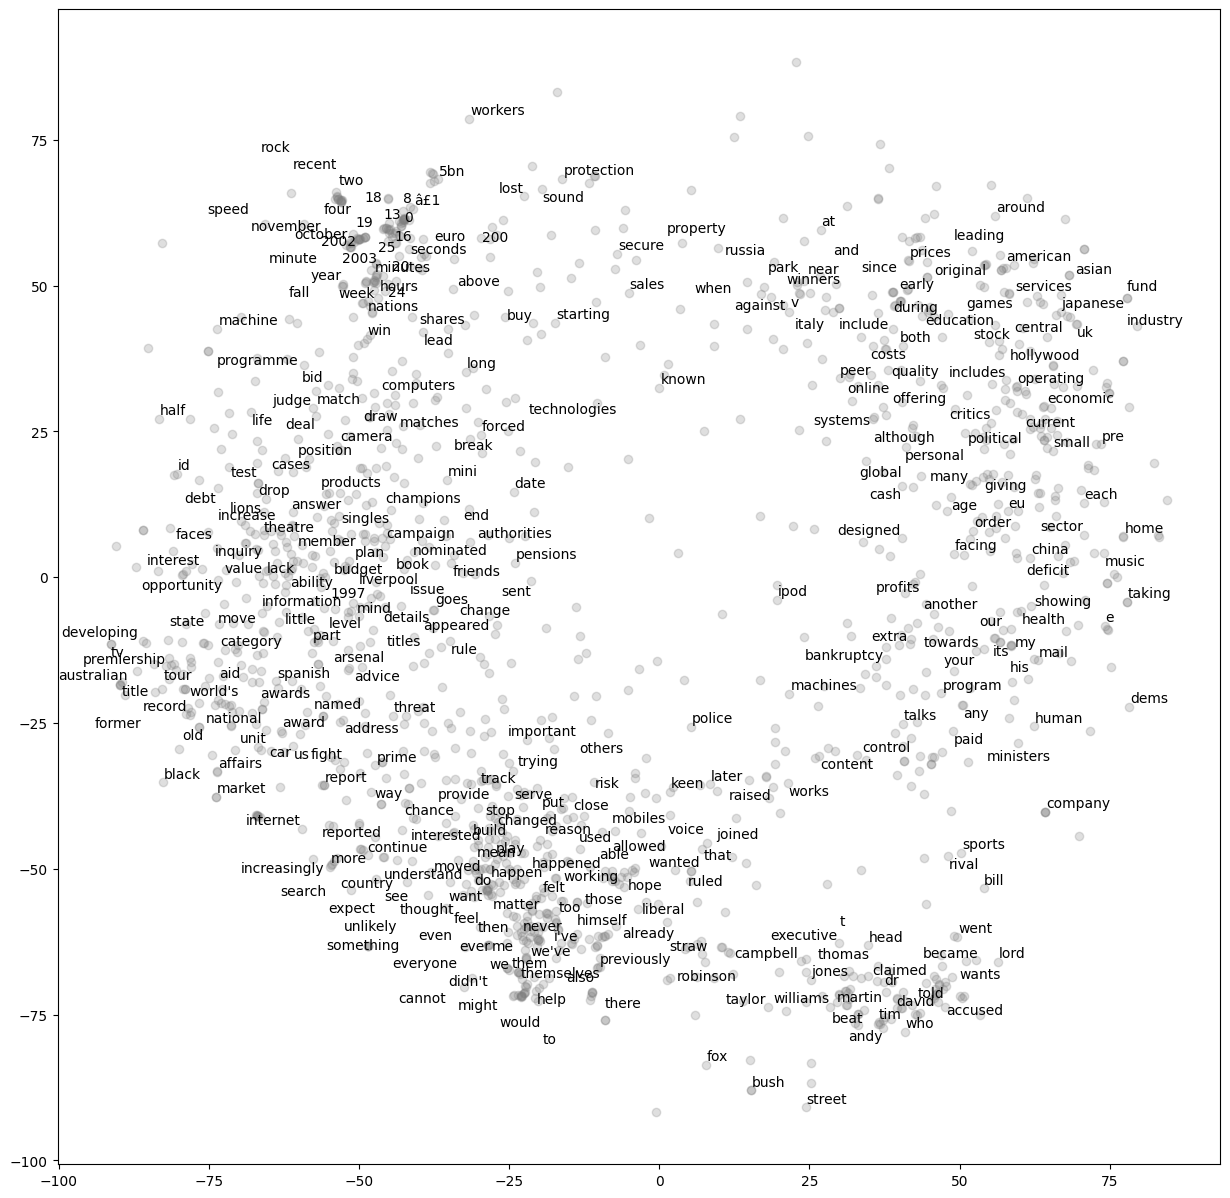

In [31]:
def plot(embeddings, labels):
    print(f"Plotting {embeddings.shape[0]} points")
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
    plt.figure(figsize=(15,15))  # in inches
    
    # plot all the embeddings and their corresponding words
    plot_annotations = []
    
    for i, label in enumerate(labels):
        
        x, y = embeddings[i,:]
        plt.scatter(x, y, alpha=0.25, c='gray')
        
        # We only annotate a small fraction of data, to avoid long waiting times
        if np.random.normal()>0.75:
            plot_annotations.append(
                plt.text(x, y, label, ha='center', va='center', fontsize=10)
            )
    
    print(
        f"Adjusting text annotations in the plot. This may take some time: Annotations {len(plot_annotations)}"
    )
    adjust_text(plot_annotations)
    
    # use for saving the figure if needed
    #plt.savefig('word_embeddings.png')
    plt.show()

    
plot(tsne_embeddings[1:1501], skipgram_words[1:1501])


Fitting embeddings to T-SNE. This can take some time ...
Plotting 1500 points
Adjusting text annotations in the plot. This may take some time: Annotations 359


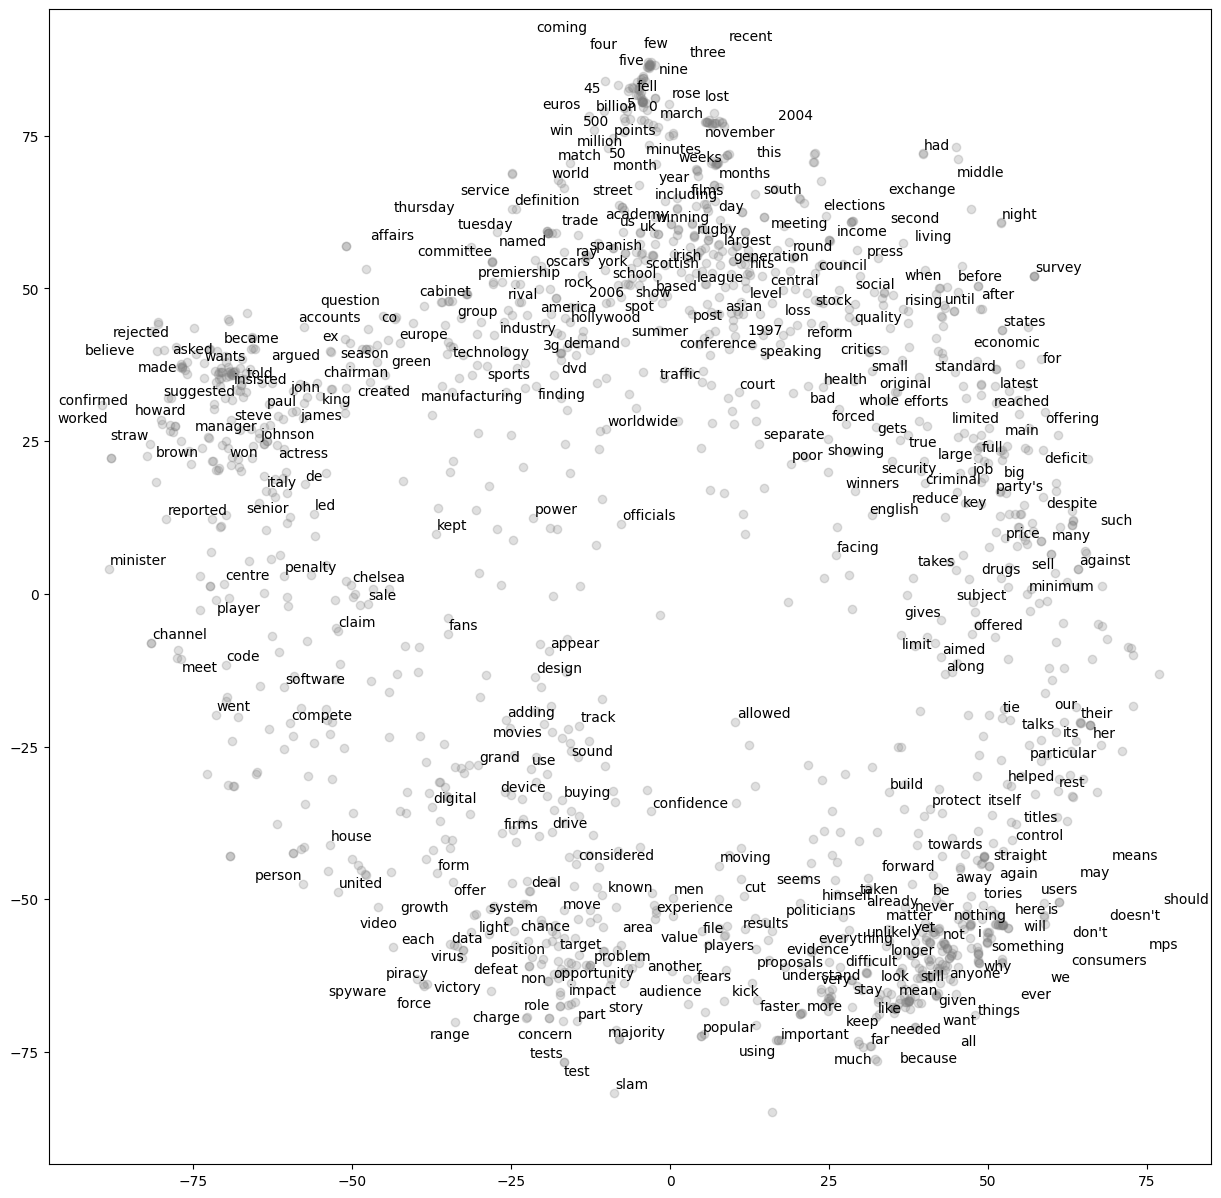

In [32]:
cbow_context_embeddings = pd.read_pickle(
    os.path.join('cbow_embeddings', 'context_embedding.pkl')
)

cbow_words, cbow_embeddings = np.array(cbow_context_embeddings.index), cbow_context_embeddings.values

tsne = TSNE(perplexity=30, n_components=2, n_iter=5000, metric='cosine')

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold

cbow_embeddings_norm = cbow_embeddings / np.sum(cbow_embeddings**2, keepdims=True, axis=1)
cbow_tsne_embeddings = tsne.fit_transform(cbow_embeddings_norm)

plot(cbow_tsne_embeddings[1:1501], cbow_words[1:1501])

In [33]:
endTime = time.time()
elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Thursday, January 19, 2023
# Run Time: 00:32:25
